# EX-12 News Summarization - Project

### 곽상혁

### 2022-12-22 (목)

https://github.com/docosa2/

## 라이브러리 버전 확인

In [33]:
from importlib.metadata import version
import nltk
import tensorflow
import summa

from bs4 import BeautifulSoup
import re

print(nltk.__version__)
print(tensorflow.__version__)
print(version('summa'))

3.7
2.9.0
1.2.0


In [22]:
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/ksh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Step 1. 데이타 수집하기

In [4]:
import pandas as pd
import urllib.request

urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [6]:
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98401


In [5]:
data.sample(10)

,headlines,text
29222,"21 govt banks lost Ã¢ÂÂ¹25,775 crore in bank ...",Twenty-one state-owned banks have incurred los...
40674,"Man, son arrested for possessing tiger skin in...",Police have arrested a 62-year-old man and his...
37902,"We feel frightened, being used for political e...",Amid protests led by Delhi CM Arvind Kejriwal ...
9410,Indira is remembered for fierce commitment to ...,"Conferring the Indira Gandhi Prize for Peace, ..."
57299,North Korea agrees to communicate regularly wi...,North Korea has agreed to communicate regularl...
92175,Fur coat worn by Titanic survivor sells for ov...,A fur coat worn by a stewardess aboard the Tit...
95707,Payments made against fake bills during Kabadd...,A report by the Comptroller and Auditor Genera...
113,"Pay Ã¢ÂÂ¹25,000 to contest LS polls: AIADMK t...",All India Anna Dravida Munnetra Kazhagam (AIAD...
13735,Case filed against fan who tried to kiss Virat...,A case of trespassing was filed against the fa...
83886,Premji's PremjiInvest objects $30 mn for Snapd...,Wipro Chairman and billionaire Azim Premji's f...


이 데이터는 기사의 본문에 해당되는 text와 headlines 두 가지 열로 구성되어져 있습니다.

추상적 요약을 하는 경우에는 text를 본문, headlines를 이미 요약된 데이터로 삼아서 모델을 학습할 수 있어요. 추출적 요약을 하는 경우에는 오직 text열만을 사용하세요.



## Step 2. 데이터 전처리하기 (추상적 요약)

실습에서 사용된 전처리를 참고하여 각자 필요하다고 생각하는 전처리를 추가 사용하여 텍스트를 정규화 또는 정제해 보세요. 만약, 불용어 제거를 선택한다면 상대적으로 길이가 짧은 요약 데이터에 대해서도 불용어를 제거하는 것이 좋을지 고민해 보세요.

### 중복 샘플과 NULL 값이 존재하는 샘플 제거

#### 각 칼럼별 중복 샘플 수 확인

In [9]:
print('headline 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())

headline 열에서 중복을 배제한 유일한 샘플의 수 : 98280
text 열에서 중복을 배제한 유일한 샘플의 수 : 98360


#### text 칼럼을 이용하여 중복 샘플 제거

In [12]:
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


#### Null 값 확인

In [13]:
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


#### Null 값 제거

In [14]:
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


### 텍스트 정규화와 불용어 제거

#### 텍스트 정규화(text normalization)

In [15]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


#### 불용어

In [21]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

#### 전처리 함수

In [34]:
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (headline)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

#### 전체 text에 대해 전처리를 실시

In [35]:
clean_text = []
# 전체 Text 데이터에 대한 전처리
for s in data['text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
print("Text 전처리 후 결과: ", clean_text[:5])

Text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

In [37]:
clean_headlines = []
# 전체 headlines 데이터에 대한 전처리
for h in data['headlines']:
    clean_headlines.append(preprocess_sentence(h, False)) # 불용어 제거를 수행하지 않음

print("headlines 전처리 후 결과: ", clean_headlines[:5])

/Users/ksh/miniforge3/envs/tutorial/lib/python3.9/site-packages/bs4/__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


headlines 전처리 후 결과:  ['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


#### 데이타프레임으로 변환

In [38]:
data['headlines'] = clean_headlines
data['text'] = clean_text

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

In [39]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

In [40]:
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


### 문서의 최대 길이 정하기

#### text와 headlines의 최소, 최대, 평균 길이를 구하고 또한 길이 분포를 시각화

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
헤드라인의 최소 길이 : 1
헤드라인의 최대 길이 : 16
헤드라인의 평균 길이 : 9.299532330215534


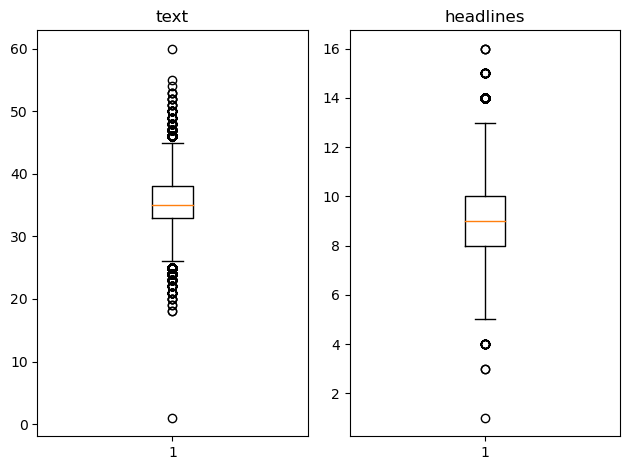

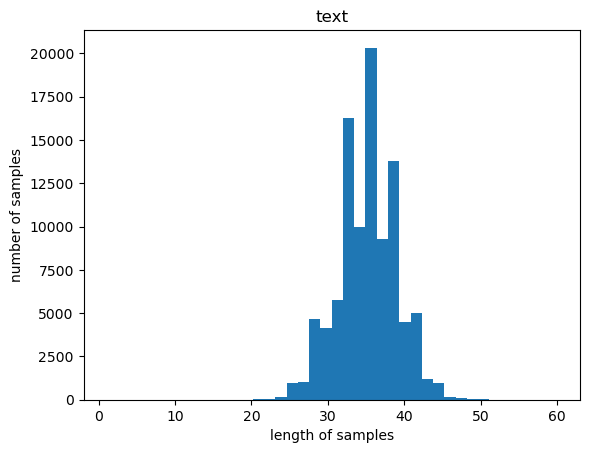

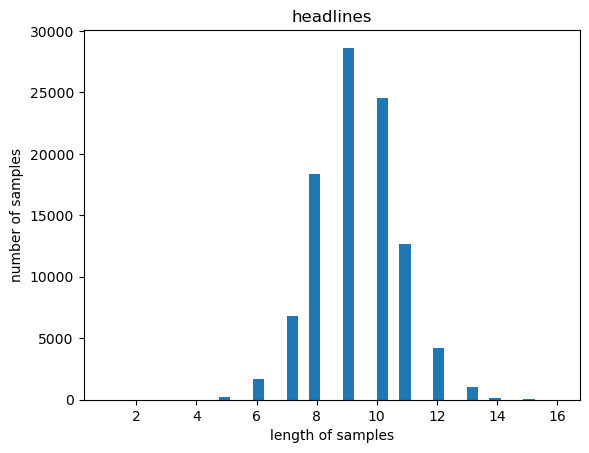

In [41]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('헤드라인의 최소 길이 : {}'.format(np.min(headlines_len)))
print('헤드라인의 최대 길이 : {}'.format(np.max(headlines_len)))
print('헤드라인의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('text')
plt.subplot(1,2,2)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.tight_layout()
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

##### 문장 최대 길이 설정 

In [61]:
text_max_len = 38
headlines_max_len = 10

##### 문장 길이에 따른 비율 확인

In [62]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [63]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len,  data['headlines'])

전체 샘플 중 길이가 38 이하인 샘플의 비율: 0.8163379422529483
전체 샘플 중 길이가 10 이하인 샘플의 비율: 0.8162972753151687


In [64]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 65295


### 시작 토큰과 종료 토큰 추가

In [65]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...
9,cong wins ramgarh bypoll in rajasthan takes to...,congress candidate shafia zubair ramgarh assem...,sostoken cong wins ramgarh bypoll in rajasthan...,cong wins ramgarh bypoll in rajasthan takes to...
10,up cousins fed human excreta for friendship wi...,two minor cousins uttar pradesh gorakhpur alle...,sostoken up cousins fed human excreta for frie...,up cousins fed human excreta for friendship wi...


### 데이타 준비

In [66]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

### 훈련 - 시험 데이타 분리

In [67]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[62644 18236 37810 ...  6330 56976 56119]


#### 셔플 데이타

In [68]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

#### 데이타 분리 비율 설정

In [69]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 13059


#### 데이타 분리

In [70]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 52236
훈련 레이블의 개수 : 52236
테스트 데이터의 개수 : 13059
테스트 레이블의 개수 : 13059


### 인코딩 : 단어 집합 만들기 및 정수 인코딩

#### 인코딩용 토크나이저

In [73]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

##### 단어 빈도수 확인

In [77]:
threshold = 10 # 단어 등장 빈도 역치

total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 57286
등장 빈도가 9번 이하인 희귀 단어의 수: 42670
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 14616
단어 집합에서 희귀 단어의 비율: 74.48591278846489
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.977536033029666


In [78]:
src_vocab = 14000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 14,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

##### 정수 시퀀스로 변환

In [79]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[4310, 356, 7218, 299, 1, 1346, 1717, 2674, 924, 1676, 538, 12037, 295, 818, 7219, 3211, 6434, 4310, 74, 1676, 2366, 29, 121, 12037, 818, 8655, 150, 5037, 411, 1384, 1428, 2076, 1676, 1, 2142, 4074, 4310, 241], [4, 283, 1346, 2948, 2533, 1905, 1027, 1958, 13, 1652, 2034, 54, 1367, 4169, 155, 31, 1731, 697, 240, 300, 10726, 675, 1905, 1015, 90, 264, 1905, 565, 12038, 1542, 4, 2403, 16], [4033, 9346, 1340, 5316, 4259, 9347, 873, 5164, 10727, 1587, 12592, 9079, 1818, 44, 10343, 6924, 631, 2579, 3943, 960, 1, 7220, 9347, 840, 911, 6563, 1266, 6085, 203, 1132]]


#### 디코딩용 토크나이저

In [80]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

##### 타이틀 단어 빈도수 확인

In [83]:
threshold = 5
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 25843
등장 빈도가 4번 이하인 희귀 단어의 수: 16391
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 9452
단어 집합에서 희귀 단어의 비율: 63.42529892040398
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.456242679830143


##### 타이틀 정수 시퀀스로 변환

In [84]:
tar_vocab = 9000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 891, 758, 14, 4, 8, 2081], [1, 2444, 1178, 1524, 2519, 6, 10], [1, 1639, 107, 4472, 6949, 5952], [1, 561, 183, 1989, 102, 6, 8450, 281], [1, 111, 6, 5572, 3, 1546, 2597, 3478, 2141, 15]]
target
decoder  [[891, 758, 14, 4, 8, 2081, 2], [2444, 1178, 1524, 2519, 6, 10, 2], [1639, 107, 4472, 6949, 5952, 2], [561, 183, 1989, 102, 6, 8450, 281, 2], [111, 6, 5572, 3, 1546, 2597, 3478, 2141, 15, 2]]


#### 데이타의 길이 확인 및 유효한 단어가 포함되지 않은 데이타는 정리

In [85]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 52236
훈련 레이블의 개수 : 52236
테스트 데이터의 개수 : 13059
테스트 레이블의 개수 : 13059


### 패딩 : 시퀀스 패딩

In [87]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')

## Step 3. 어텐션 메커니즘 사용하기 (추상적 요약)

일반적인 seq2seq보다는 어텐션 메커니즘을 사용한 seq2seq를 사용하는 것이 더 나은 성능을 얻을 수 있어요. 실습 내용을 참고하여 어텐션 메커니즘을 사용한 seq2seq를 설계해 보세요.

### 모델 설계하기

#### 인코더

In [88]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
# encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
# encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
# encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

Metal device set to: Apple M2


2022-12-22 23:26:16.659934: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-22 23:26:16.660647: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


#### 디코더

In [89]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

#### 출력층

In [90]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

#### 모델 인스턴스

In [91]:
# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 38)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 38, 128)      1792000     ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 38, 256),    394240      ['embedding[0][0]']              
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                              

### 어텐션 모델 설계하기

#### 어텐션층 정의

In [92]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

#### 어텐션층과 인코더, 디코더 연결  

In [94]:
# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])

#### 어텐션층의 출력과 디코더 hidden state 연결

In [95]:
# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#### 출력층

In [96]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

#### 모델 인스턴스

In [97]:
# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 38)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 38, 128)      1792000     ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 38, 256),    394240      ['embedding[0][0]']              
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                            

## 모델 훈련하기

In [98]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50


2022-12-22 23:35:23.048219: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-12-22 23:35:25.182921: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-22 23:35:25.291756: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
2022-12-22 23:35:25.600075: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-22 23:35:25.843703: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-22 23:35:25.907632: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_regi

  1/205 [..............................] - ETA: 14:14 - loss: 9.1050

2022-12-22 23:35:27.133109: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


205/205 [==============================] - ETA: 0s - loss: 6.5087

2022-12-22 23:36:01.956603: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-22 23:36:01.997047: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
2022-12-22 23:36:02.065450: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-22 23:36:02.134680: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-22 23:36:02.205309: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-22 23:36:02.271850: I tensorflow/core/grappler/opti

205/205 [==============================] - 43s 190ms/step - loss: 6.5087 - val_loss: 6.0727
Epoch 2/50
205/205 [==============================] - 37s 182ms/step - loss: 5.9859 - val_loss: 5.8189
Epoch 3/50
205/205 [==============================] - 37s 182ms/step - loss: 5.7274 - val_loss: 5.7233
Epoch 4/50
205/205 [==============================] - 37s 182ms/step - loss: 5.4858 - val_loss: 5.3637
Epoch 5/50
205/205 [==============================] - 37s 182ms/step - loss: 5.2340 - val_loss: 5.1888
Epoch 6/50
205/205 [==============================] - 37s 182ms/step - loss: 5.0000 - val_loss: 4.9988
Epoch 7/50
205/205 [==============================] - 37s 182ms/step - loss: 4.7661 - val_loss: 4.8522
Epoch 8/50
205/205 [==============================] - 37s 182ms/step - loss: 4.5514 - val_loss: 4.7227
Epoch 9/50
205/205 [==============================] - 37s 182ms/step - loss: 4.3460 - val_loss: 4.6106
Epoch 10/50
205/205 [==============================] - 37s 183ms/step - loss: 4.1551

### 훈련 과정 시각화

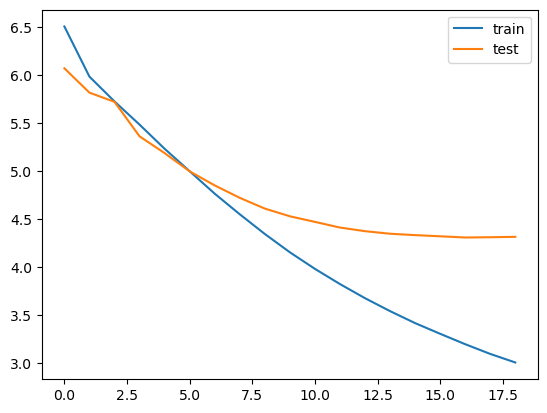

In [99]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## 추론 모델 구현

### 단어 복원용 사전 준비

In [100]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

### 추론용 모델 설계

In [101]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])


### 추론용 어텐션층 설계

In [102]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

### 추론 시 단어 시퀀스를 만들어 주는 함수

In [106]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

## 추론 모델 시험

### 시퀀스 변환 함수 : 정수 - 단어

In [107]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2headlines(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

## Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)

원래의 요약문(headlines 열)과 학습을 통해 얻은 추상적 요약의 결과를 비교해 보세요.

In [108]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 헤드라인 :", seq2headlines(decoder_input_test[i]))
    print("예측 헤드라인 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : congress mp jyotiraditya scindia arrested tuesday madhya pradesh way visit mandsaur several farmers killed police firing protests congress vice president rahul gandhi also arrested last week making attempts enter area without permission meet farmers families 
실제 헤드라인 : scindia arrested on his way to mp violence hit mandsaur 
1/1 [==============================] - 0s 10ms/step
예측 헤드라인 :  rahul gandhi arrested in mp rahul gandhi arrested


원문 : woman left newborn baby bathroom us airport reportedly gave birth inside airport baby left note read please help please get authorities find good home authorities hoping identify mother 
실제 헤드라인 : woman gives birth in us airport baby in 
1/1 [==============================] - 0s 9ms/step
예측 헤드라인 :  woman delivers baby on flight flight gets her


원문 : batsman prithvi shaw turns today smashed runs balls year old harris shield match rizvi st francis shaw innings lasted minutes two days included fours five sixes run knock highest score indian bat

1/1 [==============================] - 0s 9ms/step
예측 헤드라인 :  bumrah is the bowling bowling


원문 : juhi parmar played lead role television show talking single parent said single parent last two years every day challenging single parent tough child loves keeps going added juhi recently got divorced ex husband sachin shroff 
실제 헤드라인 : every day challenge actress on being single parent 
1/1 [==============================] - 0s 8ms/step
예측 헤드라인 :  dilip kumar to show in november


원문 : according reports varun dhawan star remake comedy film biwi directed varun father david dhawan also directed original film start work film coming year casting leading ladies begin final script locked said source 
실제 헤드라인 : varun dhawan to star in remake of no reports 
1/1 [==============================] - 0s 9ms/step
예측 헤드라인 :  varun dhawan to star in varun judwaa report


원문 : uk based study revealed freezing temperatures deep waters could hamper oil bacteria ability help oceans recover researchers found 

1/1 [==============================] - 0s 8ms/step
예측 헤드라인 :  neymar congratulates messi for his first time


원문 : planet solar system nearly right angle orbit tilt possibly occurred due planet collision earth sized object long ago seventh planet sun discovered march british astronomer william 
실제 헤드라인 : only planet in the solar system that 
1/1 [==============================] - 0s 9ms/step
예측 헤드라인 :  nasa spacecraft completes years of mars


원문 : runs youtube channel asked fans insult india new video comes fans started posting offensive comments india amid concerns series take youtube channel youtuber also announced started ngo cry india 
실제 헤드라인 : top youtuber asks fans not to insult india over series 
1/1 [==============================] - 0s 10ms/step
예측 헤드라인 :  bans users from arsenal of tennis channels


원문 : search giant google incorporated years ago th september co founders larry page sergey brin google homepage maintained look since founders adequate knowledge notably google 

1/1 [==============================] - 0s 9ms/step
예측 헤드라인 :  bjp leader booked for forcing woman to celebrate wedding


원문 : bjp leader arun friday said made many mistakes supporting vp singh supporting narendra modi speaking recognise singh festival former cabinet minister added believe leaders suddenly change come power 
실제 헤드라인 : supporting narendra modi was mistake arun 
1/1 [==============================] - 0s 9ms/step
예측 헤드라인 :  bjp mp calls for calling india slogan


원문 : indian origin couple threatened racially abused man canada hamilton city told go back country threatened kill children argument reportedly started couple tried back parking spot apparently got man way police investigating incident hate crime 
실제 헤드라인 : will kill your kids canadian threatens indian origin couple 
1/1 [==============================] - 0s 9ms/step
예측 헤드라인 :  uk man jailed for forcing man to eat gun


원문 : union aviation ministry recommended increasing compensation flight delays cause flyers mis

1/1 [==============================] - 0s 8ms/step
예측 헤드라인 :  woman kills husband for talking to save baby


원문 : man named arrested impersonating salman khan brother law aayush sharma cheating people offering roles films created fake facebook profile name aayush married salman sister arpita according police started duping people suffered loss business 
실제 헤드라인 : who posed as salman khan brother in law arrested 
1/1 [==============================] - 0s 9ms/step
예측 헤드라인 :  man arrested for selling daughter in mumbai


원문 : commerce websites selling consumer goods held liable false claims new consumer protection bill according officials bill yet passed provides establishment central consumer protection authority prevent unfair trade practices currently national consumer helpline gets around complaints commerce firms month 
실제 헤드라인 : commerce sites to be held liable for false claims 
1/1 [==============================] - 0s 9ms/step
예측 헤드라인 :  amazon agrees to pay million for info on sa

1/1 [==============================] - 0s 8ms/step
예측 헤드라인 :  india pm justin trudeau to visit india


원문 : enforcement directorate today attached assets worth crore belonging bihar topper scam main accused rai months properties worth crore belonged case prevention money laundering act registered rai allegedly manipulated results students money contacts bihar school examination board 
실제 헤드라인 : ed attaches cr assets of bihar topper scam main accused 
1/1 [==============================] - 0s 14ms/step
예측 헤드라인 :  ed attaches assets worth crore in delhi




## Step 5. Summa을 이용해서 추출적 요약해보기

추상적 요약은 추출적 요약과는 달리 문장의 표현력을 다양하게 가져갈 수 있지만, 추출적 요약에 비해서 난이도가 높아요. 반대로 말하면 추출적 요약은 추상적 요약에 비해 난이도가 낮고 기존 문장에서 문장을 꺼내오는 것이므로 잘못된 요약이 나올 가능성이 낮아요.

Summa의 summarize를 사용하여 추출적 요약을 해보세요.

In [143]:
import requests
from summa.summarizer import summarize

In [144]:
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [145]:
news_text = data.iloc[0]['text']

In [146]:
news_headlines = data.iloc[0]['headlines']

### summazize를 사용한 문장 요약

In [147]:
news_headlines

'upGrad learner switches to career in ML & Al with 90% salary hike'

In [148]:
news_text

"Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers."

In [149]:
print(summarize(news_text, words=10))

upGrad's Online Power Learning has powered 3 lakh+ careers.
